<a href="https://colab.research.google.com/github/hungpham13/Laptop-EDA/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
! git clone https://github.com/hungpham13/Laptop-EDA/

fatal: destination path 'Laptop-EDA' already exists and is not an empty directory.


# Welcome to Laptop Market Exploratory Data Analysis !
Here we are going to take a closer look at our Laptop data that was scraped from 3 main websites: fptshop.com.vn, cellphones.com and thegioididong.com.vn. 


---


In this section, we will be analysing our data in a variety of aspect: 
+ We will divide the analysis into 3 main sections: 
  + Import data and preprocessing
  + Examine Numerical Attributes, which focus on the distributions of importants attributes and determine the relationship with other numerical columns.
  + Examine Categorical Attributes, which focus on the categories distribution and chi-square test to determine if an attribute affects others.

**NOTE: REMOVE OUTLIER OF NUMERIC ATT**

## I. Import libraries, Data and prepare data


---

Our data preparing includes importing data, drop unnecessary columns, handle missing value and prepare numerical/categorical attributes.

### Import libraries
In our Analysis today, we will mostly use matplotlib and seaborn library for ploting data; scipy library is also needed for calculating entropy and chisquare statistics - we will see in the third section.

In [52]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
import seaborn as sns
from matplotlib import cm
plt.style.use('ggplot')
cmap = cm.get_cmap('Spectral')

import pandas as pd
from pandas.api.types import is_numeric_dtype

import warnings
warnings.filterwarnings('ignore')

import scipy
from scipy import stats
from scipy.stats import chi2_contingency, entropy

### Import and explore the data
File name: `merged_data.csv`

Here we notice that the original indexes from scraped data are not useful anymore, so we should drop them. Without dropping those columns, our data later on wil have noise in calculating correlation as well as numerical attributes analysis.

In [53]:
source_data = pd.read_csv('./Laptop-EDA/merged_data.csv')
to_drop = ['Index_fpt','Index_cellphones','Index_tgdd','Unnamed: 0','P/N','Series']
main_data = source_data.drop(to_drop, axis = 1)
main_data.head()

,GPU,Comment_count,Price,Rating,Rating_count,Brand,cpu_brand,cpu_code,ram_size,storage_size,displ_size,displ_rate,Battery,OS,displ_resolution,hdmi,Release_year,Surface,Weight,backlit_keyboard,lan,length,ram_upgradable,screen_technology,sd_card,storage_extra_slot,storage_type,headphone_jack,thickness,type_c,usb_a,width,Availabe_in,GPU_brand
0,nvidia geforce rtx 3050 ti,906.0,2.862633e+07,NaN,0.0,acer,intel,11800h,8.0,512.0,15.6,144.0,57.0,windows 10,1920 x 1080,yes,2021.0,plastic,2.20,yes,yes,363.40,yes,ips,no,yes,ssd,yes,23.9,yes,yes,255.00,3,nvidia
1,nvidia geforce mx450,400.0,2.125967e+07,NaN,0.0,msi,intel,1155g7,8.0,512.0,14.0,60.0,39.0,windows 10,1920 x 1080,yes,2021.0,metal,1.30,yes,no,319.00,yes,ips,yes,no,ssd,yes,16.9,yes,yes,219.00,3,nvidia
2,intel uhd graphics,322.0,1.529450e+07,3.7,18.0,dell,intel,1115g4,4.0,256.0,15.6,60.0,41.0,windows 10,1920 x 1080,yes,2021.0,plastic,1.70,no,no,358.50,yes,va,yes,yes,ssd,yes,18.9,no,yes,235.50,2,intel
3,intel uhd graphics,378.0,1.499900e+07,5.0,4.0,lenovo,intel,1115g4,8.0,512.0,15.6,60.0,NaN,windows 10,1920 x 1080,yes,2021.0,plastic,1.65,yes,yes,359.00,yes,led,yes,yes,ssd,yes,19.9,yes,yes,237.70,1,intel
4,intel iris xe graphics,1244.0,1.879900e+07,5.0,5.0,lenovo,intel,1135g7,16.0,512.0,15.6,60.0,45.0,windows 10,1920 x 1080,yes,2021.0,"metal, plastic",1.66,yes,yes,356.67,yes,ips,yes,yes,ssd,yes,17.9,yes,yes,233.13,1,intel


In [54]:
print(main_data.shape)
print(main_data.info())

(552, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   GPU                 548 non-null    object 
 1   Comment_count       552 non-null    float64
 2   Price               496 non-null    float64
 3   Rating              168 non-null    float64
 4   Rating_count        552 non-null    float64
 5   Brand               552 non-null    object 
 6   cpu_brand           552 non-null    object 
 7   cpu_code            552 non-null    object 
 8   ram_size            552 non-null    float64
 9   storage_size        552 non-null    float64
 10  displ_size          552 non-null    float64
 11  displ_rate          552 non-null    float64
 12  Battery             489 non-null    float64
 13  OS                  548 non-null    object 
 14  displ_resolution    545 non-null    object 
 15  hdmi                548 non-null    object 
 16

This dataset contains 552 rows and 34 columns.

Here, I will explain the meaning of each columns:

+ The most important attributes to follow along is `Comment_count` (total number of comments on each product, summarized from all 3 sources), `Rating` (Rating score on scale 5 for each laptop) and the last one is `Rating_count` (number of feedback given on each laptop).
  + `Comment_count` represents the crowd attention or popularity of a product.
  + `Rating` and `Rating_count` represent how good or bad the product is, or how satisfactory customer feels with that product. 
+ `Price`: the sale price of each laptop in Vietnamese currency (VND)
+ `Brand` and `Series`: Name of laptop's brand and its particular model name 
+ `cpu_brand` and `cpu_code`: Name of CPU's manufacturer and the CPU model number
- Ram specs (2 variables)
    - `ram_size` (GB)
    - `ram_upgradable`: has extra slot to expand ram capacity or not
- Storage specs (3 variables)
    - `storage_size`: storage capacity of laptop's hard drive (GB)
    - `storage_type`: hard drive type (SSD, HDD, eMMC)
    - `storage_extra_slot`: has extra slot to expand storage capacity or not
- Display specs (4 variables)
    - `displ_size`: display size (inch)
    - `displ_resolution`: display resolution (1920 x 1080, 2560 x 1600,...)
    - `displ_rate`: display refresh rate (Hz)
    - `screen_technology`: panel type (IPS, VA, OLED,..)
- Size and Weight of the product (4 variables)
    - `Weight` (kg)
    - `length`, `width`, `thickness` (mm)		
- `GPU`: main graphics card (integrated or discrete)
- `Battery`: battery capacity (Wh)
- `OS`: Operating system pre-installed on the device
- `Surface`: Material of the case (plastic, aluminum, carbon,...)
- `Release_year`: Release year of the laptop
<!-- + For more precise look and better insights, we will need to examine some other attributes ralated to the technological details of our products such as: -->
- Ports and special features (7 variables)
    - `hdmi`: has hdmi socket or not
    - `headphone_jack`: has 3.5mm headphone plug or not
    - `lan`: has ethernet lan port or not
    - `type_c`: has USB Type-C socket or not
    - `usb_a`: has USB socket or not
    - `sd_card`: has sd card socket or not 
    - `backlit_keyboard`: whether the keyboard have backlight under the keys or not

### Normalize `Rating_count` and `Comment_count`

In [55]:
main_data['Comment_count'] = main_data['Comment_count']/main_data['Availabe_in']
main_data['Rating_count'] = main_data['Rating_count']/main_data['Availabe_in']
main_data = main_data.drop('Availabe_in',axis=1)

### Identify cagetorical and numeric variables

In [56]:
def add_number(ax,orient='h'):
    if orient == 'h':
        for p in ax.patches:
            # plt.text(x = , y = p.get_y() + 0.55 * p.get_height(), s = f'{int(p.get_width())}')
            ax.annotate(f"{float(p.get_width()):.1f}",
                            xy = (p.get_width(), p.get_y() + 0.5*p.get_height()), 
                             va = 'center', 
                            xytext = (5, 0), 
                            textcoords = 'offset points')
    elif orient == 'v':
        for p in ax.patches:
            ax.annotate(f"{float(p.get_height()):.1f}", 
                            xy = (p.get_x() + p.get_width() /2, p.get_height()), 
                            ha = 'center', va = 'center', 
                            xytext = (0, 8), 
                            textcoords = 'offset points')

In [57]:
numeric_attributes = main_data[[c for c in main_data.columns 
                                # if main_data[c].value_counts().count() > 20
                                if is_numeric_dtype(main_data[c])]]
categorical_attributes = main_data[[c for c in main_data.columns if c not in numeric_attributes.columns]]

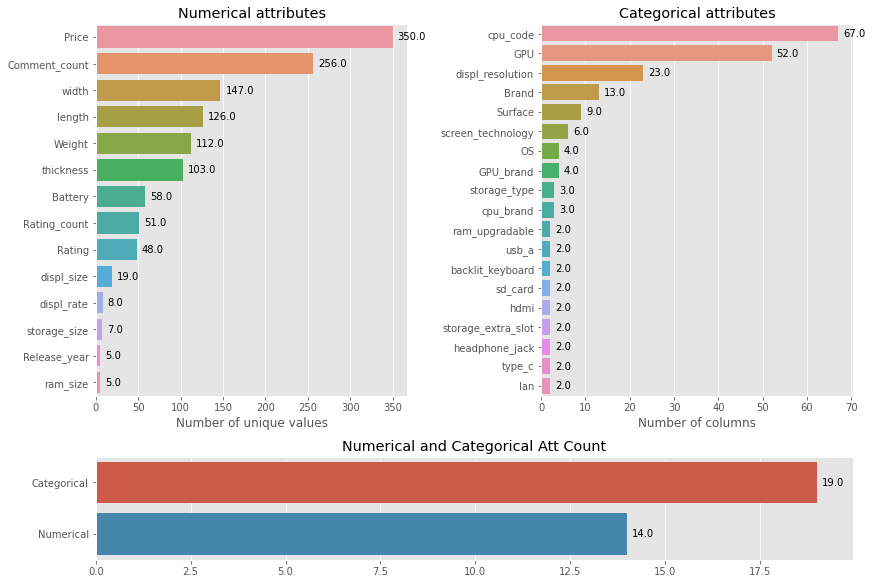

<Figure size 360x432 with 0 Axes>

In [58]:
fig = plt.figure(constrained_layout=True,figsize=(12,8))
gs = fig.add_gridspec(3, 2)
ax0 = fig.add_subplot(gs[0:2,0])
ax1 = fig.add_subplot(gs[0:2,1])
ax2 = fig.add_subplot(gs[2,:])

numeric_unique = numeric_attributes.nunique().sort_values(ascending=False)
sns.barplot(y=numeric_unique.index,x=numeric_unique.values,ax=ax0)
ax0.set_title('Numerical attributes')
ax0.set_xlabel('Number of unique values')
add_number(ax0)

cate_unique = categorical_attributes.nunique().sort_values(ascending=False)
sns.barplot(y=cate_unique.index,x=cate_unique.values,ax=ax1)
ax1.set_title('Categorical attributes')
ax1.set_xlabel('Number of unique values')
add_number(ax1)

fig = plt.figure(figsize=(5,6))
y = [len(categorical_attributes.columns), len(numeric_attributes.columns)]
sns.barplot(y=['Categorical', 'Numerical'],x= y,ax=ax2)
ax2.set_title('Numerical and Categorical Att Count')
ax1.set_xlabel('Number of columns')
add_number(ax2)


### Fill null
After checking the information of the remaining data, there are a lot of columns that still have null value. To handle this, we might choose either to drop all the missing row or to fill in the null values with appropriate value. 

Since our data is quite small in size, dropping all rows with null value is wasting information so filling in the missing value should be considered. For numerical attributes, we fill null by the mean of that columns. For categorical attributes, we simply replace null with "NaN"

Text(0, 0.5, 'Columns')

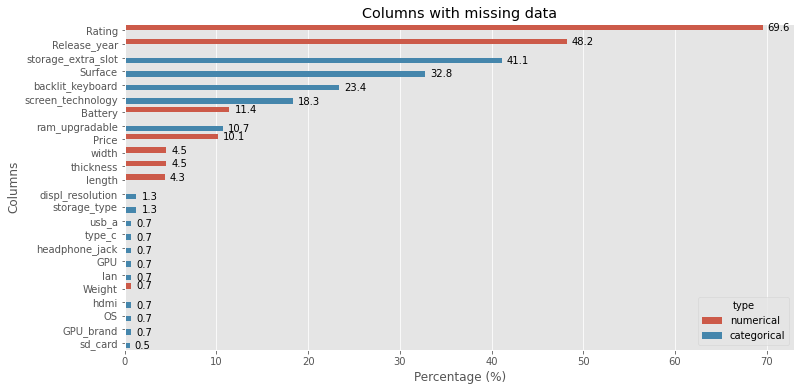

In [59]:
null_list = [[c,main_data[c].isnull().sum(axis=0)/len(main_data)*100] for c in main_data.columns 
             if main_data[c].isnull().sum(axis=0) != 0]
df_null = pd.DataFrame.from_records(null_list, columns=['col','missing_percent'])
df_null = df_null.sort_values('missing_percent',axis=0, ascending = False)
df_null['type'] = np.where(df_null.col.str.contains('|'.join(categorical_attributes.columns)), 'categorical','numerical')
# print(df_null)

plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_null, y='col', x='missing_percent', hue='type')
add_number(ax,orient='h')
# plt.xticks(rotation = 45,ha='right')
plt.title('Columns with missing data')
plt.xlabel('Percentage (%)')
plt.ylabel('Columns')

In [60]:
# for att in numeric_attributes.columns:
#     main_data[att].fillna(main_data[att].mean(), inplace = True)
for att in categorical_attributes.columns:
    main_data[att].fillna('NaN', inplace = True)

In [61]:
def text_facet(col, df=main_data, print_all=True,ascending=False):
    if print_all:
        with pd.option_context('display.max_rows', 1000, 'display.max_columns', None):
            print(f"---------- {col} ------------")
            print(df[col].value_counts(dropna=False,ascending=ascending))
    else:
        print(f"---------- {col} ------------")
        print(df[col].value_counts(dropna=False,ascending=ascending))
        print(f"Number of null: {df[col].isna().sum()}")

text_facet('Battery')

---------- Battery ------------
NaN      63
41.0     58
42.0     49
45.0     32
48.0     29
65.0     23
90.0     23
37.0     21
56.0     18
76.0     15
50.0     13
80.0     13
52.0     12
67.0     12
60.0     12
57.0     12
39.0     10
51.0     10
54.0      9
40.0      8
58.0      7
38.0      6
66.0      6
53.0      6
70.0      5
59.0      5
36.0      5
57.5      5
68.0      4
82.0      4
150.0     4
63.0      4
35.0      4
99.0      4
43.0      4
99.9      3
72.0      3
200.0     3
120.0     2
240.0     2
100.0     2
180.0     2
60.7      2
32.0      2
62.0      2
33.0      1
49.0      1
52.5      1
30.0      1
170.0     1
53.5      1
75.0      1
44.5      1
64.0      1
56.5      1
47.0      1
71.0      1
70.9      1
36.7      1
Name: Battery, dtype: int64


### Detect outliers
In this part, we will use Z-score function defined in scipy library to detect the outliers. The threshold for detection is 3

In [62]:
col_to_detect = ['Weight','length','thickness','width']
df_to_detect = numeric_attributes[col_to_detect].dropna()
# with pd.option_context('display.max_rows', 1000, 'display.max_columns', None):
df_to_detect[(np.abs(stats.zscore(df_to_detect)) > 3)].append(df_to_detect[df_to_detect.Weight == 0]).join(source_data[['Series','Index_fpt','Index_tgdd','Index_cellphones']])

,Weight,length,thickness,width,Series,Index_fpt,Index_tgdd,Index_cellphones
153,0.775,201.0,292.0,8.5,surface pro 7 core 2019,75.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
153,0.775,201.0,292.0,8.5,surface pro 7 core 2019,75.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
153,0.775,201.0,292.0,8.5,surface pro 7 core 2019,75.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
158,0.775,201.0,292.0,8.5,surface pro 7 2019,93.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
158,0.775,201.0,292.0,8.5,surface pro 7 2019,93.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
158,0.775,201.0,292.0,8.5,surface pro 7 2019,93.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
159,0.775,201.0,292.0,8.5,surface pro 7 2019,106.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
159,0.775,201.0,292.0,8.5,surface pro 7 2019,106.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
159,0.775,201.0,292.0,8.5,surface pro 7 2019,106.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
162,1.810,361.4,199.0,249.0,vostro v3500 7g3982,114.0,NaN,https://cellphones.com.vn/laptop-dell-vostro-1...


## II. Numeric attributes analysis

---


For numerical attributes, the first thing to pay attention is the distribution of that attributes, and the distribution among multiple attributes. From there, we can explore and come up with deep insight of our data. In this section, we will plot out some statistics of the most important properties to know better about our data's balance, relation and deduce some conclusion.

Firstly, we will head up to the analysis of our 3 most important variables - the respond variables: `Comment_count`, `Rating`, `Rating_count`

In [63]:
def plot_statistics(df: pd.DataFrame, bins = 100, title = None,discrete=False):
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex= True, gridspec_kw={"height_ratios": (.15, .85)})
    fig.set_figheight(5)
    fig.set_figwidth(10)
    ax_box.set_title(title)
    sns.boxplot(df, ax=ax_box)
    if not discrete:
        sns.distplot(df, ax=ax_hist, bins = bins)
    else:
        sns.countplot(df.sort_values(),ax=ax_hist)
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)


### `Comment_count`, `Rating` and `Rating_count`

With our 3 primary attributes of concern, distribution of each feature is also needed along with the statistics information.

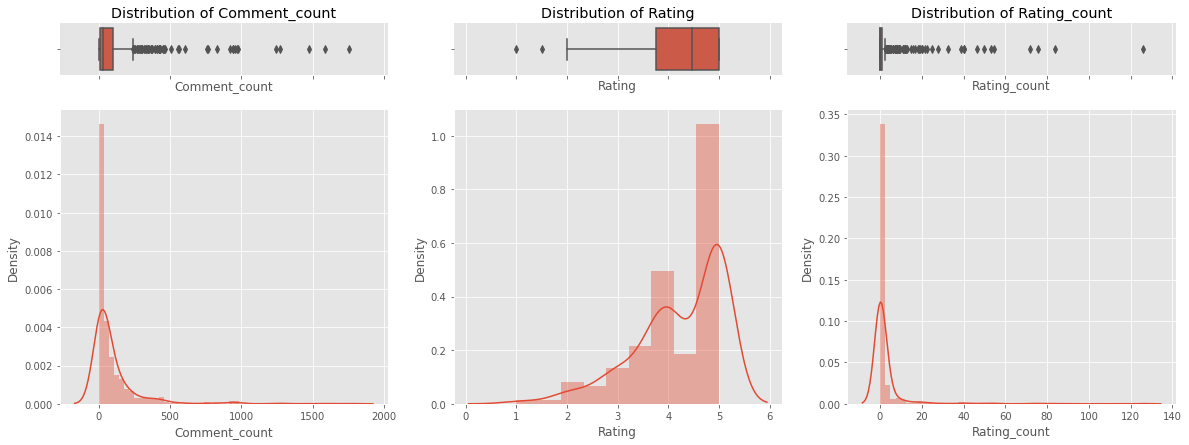

In [64]:
primary_attributes = main_data[['Comment_count','Rating','Rating_count']]
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (20,7),sharex='col',gridspec_kw={"height_ratios": (.15, .85)})
for i, att in enumerate(primary_attributes.columns):
    sns.boxplot(primary_attributes[att], ax=ax[0,i])
    sns.distplot(primary_attributes[att], ax = ax[1,i])
    sns.despine(ax=ax[1,i])
    sns.despine(ax=ax[0,i], left=True)
    ax[0,i].set_title('Distribution of '+att)

Taken the very first look at the Density plot of 3 above features, it can be seen clearly that these features are significantly imbalance. The maximum values of *Comment_count* and *Rating_count* lies far beyond the center distribution and almost remain values is 0.

We will examine the statistical information of each attributes and histogram plot to get a better look.

The first attributes is *Comment_count*:

count     552.000000
mean      102.116244
std       197.811320
min         0.000000
25%        11.000000
50%        33.000000
75%       104.250000
max      1756.000000
Name: Comment_count, dtype: float64


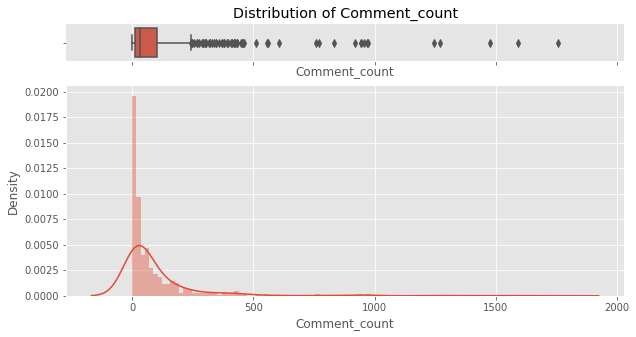

In [65]:
print(main_data.Comment_count.describe())
plot_statistics(main_data.Comment_count, bins = 100, title = 'Distribution of Comment_count')

Almost all comment count on product are from 0 to 104 comments (75% quantile), but some products seems to have the high interest controversial and has so much comment (1756 comments count). 
<!-- Checking that outliers might be useful for enhancing sale experience, but not really help in general analysis, so we will head to the next attributes `Rating`. -->

count    552.000000
mean       2.551932
std        9.917868
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max      126.000000
Name: Rating_count, dtype: float64


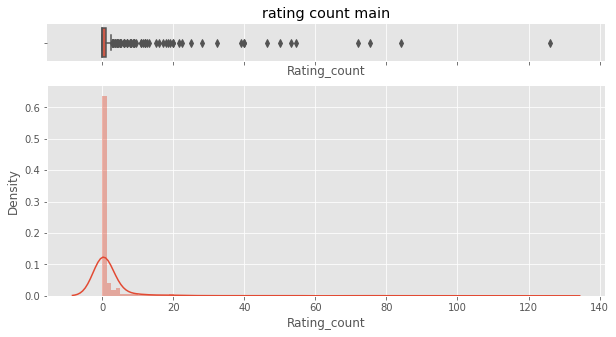

In [66]:
print(main_data.Rating_count.describe())
plot_statistics(main_data.Rating_count, bins = 100, title = 'rating count main')

In [67]:
low_rating_count = main_data[main_data.Rating_count <= main_data.Rating_count.mean()]
high_rating_count = main_data[main_data.Rating_count > main_data.Rating_count.mean()]

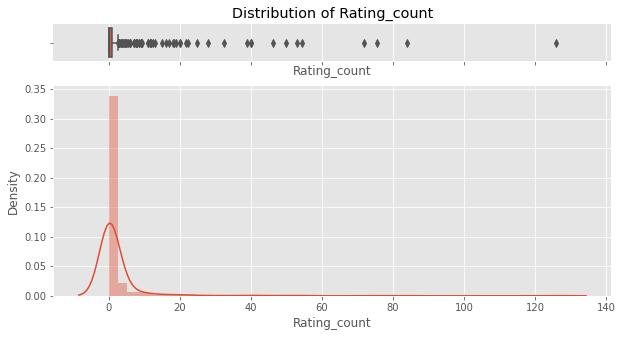

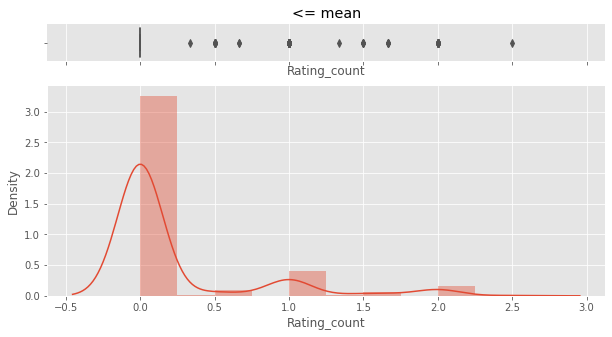

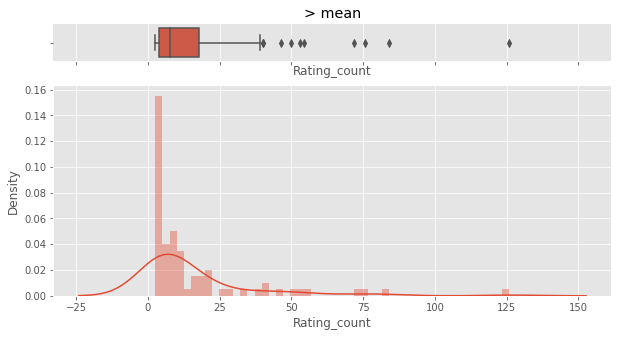

In [68]:
plot_statistics(main_data.Rating_count, bins = 50,title='Distribution of Rating_count')
plot_statistics(low_rating_count.Rating_count, bins = 10, title = '<= mean')
plot_statistics(high_rating_count.Rating_count, bins = 50, title = '> mean')

In [69]:
main_data.Rating.describe()

count    168.000000
mean       4.224201
std        0.880984
min        1.000000
25%        3.765000
50%        4.464286
75%        5.000000
max        5.000000
Name: Rating, dtype: float64

In [70]:
# đplot_statistics(rating, title = 'Rating Distributionđ)

NameError: ignored

In [ ]:
normalized_numeric_attributes = (numeric_attributes - numeric_attributes.mean())/numeric_attributes.std()
correlation = normalized_numeric_attributes.corr()
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(correlation, cmap=cmap, square = True, annot = True)

In [ ]:
sns.set()
cols = correlation.nlargest(k, 'Comment_count').index
#cols = numeric_attributes.columns
print(cols)
sns.pairplot(main_data[cols],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

### `Price`

count    4.960000e+02
mean     2.675048e+07
std      1.294145e+07
min      7.290000e+06
25%      1.826575e+07
50%      2.363542e+07
75%      3.154088e+07
max      9.299000e+07
Name: Price, dtype: float64


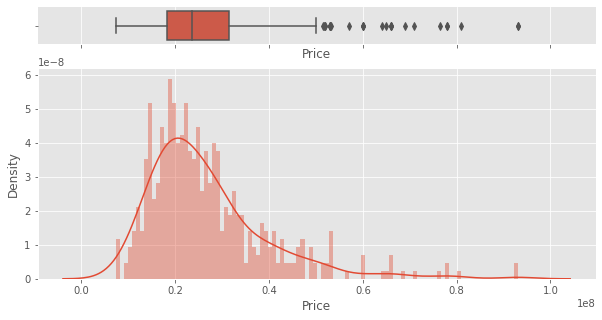

In [71]:
#Summarize some statistics information of Price and plot the distribution
print(main_data['Price'].describe())
plot_statistics(main_data['Price'])

As the plot tells, this attribute *Price* has many outliers beyond the 75% quantiles. Another point told is that the distribution of price over all product is not located at the middle but is left-shifted.

The most common price lies between 20.000.000 to 30.000.000 VND. (~ 1000 - 1500 USD)

The lowest price to afford a laptop from those sites is 7.000.000 VND (~ 350 USD) and the most luxury laptop costs ~ 93.000.000 VND (~ 4500 USD)

For further exploration, we will divide the price to 3 dimension: low, average and high by the quantile (0, 0.33, 0.67, 1.00)

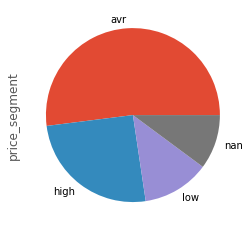

In [72]:
# low_price = main_data[main_data['Price'] < main_data['Price'].quantile(0.33)]
# avr_price = main_data[(main_data['Price'] > main_data['Price'].quantile(0.33)) &  
#                           (main_data['Price'] < main_data['Price'].quantile(0.67))]
# high_price = main_data[main_data['Price'] > main_data['Price'].quantile(0.67)]
# ultra_high_price = 0

low_price = main_data['Price'] <= 15000000
avr_price = (main_data['Price'] > 15000000) & (main_data['Price'] <= 30000000)
high_price = main_data['Price'] > 30000000
main_data['price_segment'] = np.select([low_price, avr_price, high_price],['low','avr','high'], default=np.nan)
# print('low_price:  {} \navr_price:  {} \nhigh_price: {}'.format(len(low_price), len(avr_price), len(high_price)))
main_data['price_segment'].value_counts().plot(kind='pie',xlabel="Number of price segement")
plt.show()

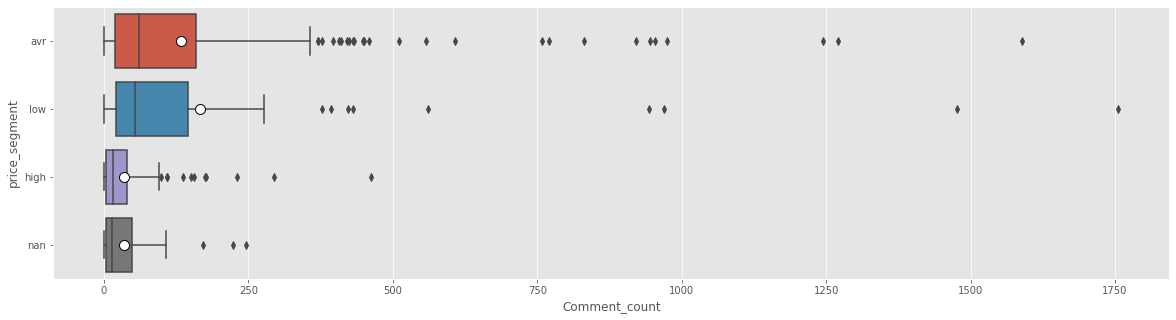

In [73]:
plt.subplots(figsize=(20, 5))
sns.boxplot(x='Comment_count', y='price_segment', data=main_data, showmeans=True, meanprops={"marker":"o", 
                                                                    "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black",
                                                                    "markersize":"10"})
# plt.ylim([0,400])
plt.show()

In [ ]:
#Plot statistics for each price dimension
plot_statistics(main_data.Price[low_price])
print('Low price dimension statistics: ', main_data.Price[low_price].describe())
plot_statistics(main_data.Price[avr_price])
print('Average price dimension statistics: ', main_data.Price[avr_price].describe())
plot_statistics(main_data.Price[high_price])
print('High price dimension statistics: ', main_data.Price[high_price].describe())

In [ ]:
x = ['low', 'avr', 'high']
y = [low_price['Comment_count'].mean(), avr_price['Comment_count'].mean(), high_price['Comment_count'].mean()]
plt.bar(x,y)

In [ ]:
plt.bar(['low', 'avr', 'high'],
        [low_price['Rating_count'].mean(), avr_price['Rating_count'].mean(), high_price['Rating_count'].mean()])

In [ ]:
ax = sns.distplot(main_data.skew())
ax.set_title('skew')
main_data.skew()

In [ ]:
fig, ax = plt.subplots(figsize = (20,9), nrows = 1, ncols = 3)
k = 8
count = 0
list_attributes = [low_price, avr_price, high_price]
for j in range(len(list_attributes)):
    att = list_attributes[j]
    normalized_att = (att - att.mean())/att.std()
    correlation = normalized_att.corr()
    cols = correlation.abs().nlargest(k, 'Comment_count').index
    zoomed_corr = np.corrcoef(main_data[cols].values.T)
    sns.heatmap(zoomed_corr,square=True,cmap=cmap, linewidths=0.01,linecolor="white",annot=True,
        xticklabels = cols.values ,yticklabels = cols.values, ax = ax[j], annot_kws = {'size':8})

### `Battery`

In [ ]:
plot_statistics(main_data.Battery)

### Discrete numeric attributes

`displ_rate`, `displ_size`, `ram_size`, `storage_size`

In [ ]:
plot_statistics(main_data['displ_rate'])
plot_statistics(main_data['displ_size'])
plot_statistics(main_data['ram_size'])
plot_statistics(main_data['storage_size'])
# plot_statistics(main_data['Release_year'])

In [ ]:
plot_statistics(main_data['displ_rate'],discrete=True)
plot_statistics(main_data['displ_size'],discrete=True)
plot_statistics(main_data['ram_size'],discrete=True)
plot_statistics(main_data['storage_size'],discrete=True)
plot_statistics(main_data['Release_year'],discrete=True)

In [ ]:
plt.figure(figsize=(15, 15))
# sns.relplot(data=main_data, x="ram_size", y="storage_size",size="Comment_count",hue="Comment_count",palette=cmap,s=0.1,alpha=.5)
sns.heatmap(data=main_data.pivot("ram_size","storage_size","Comment_count"))
# plt.xlim([200,300])
# plt.ylim([300,400])
plt.show()

### Weight and size

In [ ]:
ncols,nrows = 2,2
spec = GridSpec(ncols=ncols, nrows=nrows)
cols = ['Weight','thickness','width','length']
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15,7))
for i, att in enumerate(cols):
    plt.subplot(spec[i])
    sns.distplot(main_data[att])
    plt.xlabel('Distribution of ' + att)
plt.tight_layout()

In [ ]:
def mean_normalize(series):
    return (series-series.mean())/series.std()

In [ ]:
plt.figure(figsize=(15, 15))
sns.relplot(data=main_data, x="width", y="length",size="Comment_count",hue="Comment_count",palette=cmap,alpha=.5)
# sns.heatmap(data=main_data.pivot("width","length","Comment_count")kk)
plt.xlim([200,300])
plt.ylim([300,400])
plt.show()

In [ ]:
att_list = ['Weight', 'Comment_count', 'ram_size', 'storage_size']
fig, axis = plt.subplots(len(att_list), len(att_list),figsize=(20, 16))
for i in range(len(att_list)):
    for j in range(len(att_list)):
        var1 = att_list[i]
        var2 = att_list[j]
        if var1 == 'Rating':
            var1_data = main_data[var1].round()
        else: 
            var1_data = main_data[var1].round()
        data = pd.concat([main_data[var2], var1_data], axis=1)
        try:
          sns.boxplot(x = var1, y = var2, data = data, ax = axis[i,j])
        except:
          continue

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 7), sharey = True)
plt.xticks(rotation=90)
for i, att in enumerate(primary_attributes):
    ax[i].plot(correlation[att])
    ax[i].set_xticklabels(labels = correlation.columns,rotation=45, ha='right')

## III. Categorical analysis

---



In [ ]:
def plot_cate(col_name):
    # counter = categorical_attributes[col_name].value_counts()
    # sns.barplot(counter.values, counter.index)

    sns.countplot(y=main_data[col_name].sort_values())
    plt.xlabel('Number of laptops')
    plt.ylabel(col_name)
    plt.title('Market share of ' + col_name)


def plot_boxplot(x, y):
    sns.boxplot(y=y, x=x, data=main_data, showmeans=True, meanprops={"marker":"o", 
                                                                    "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black",
                                                                    "markersize":"10"})

### Brand

In [ ]:
plt.subplots(figsize=(10, 6))
plot_cate('Brand')

In [ ]:
plt.figure(figsize=(20, 10))
sns.histplot(x='Comment_count', hue='Brand', data=main_data[main_data['Comment_count'] > 0], kde=True, element="step")

In [ ]:
main_data['is_commented'] = main_data['Comment_count'] > 0
main_data.groupby('Brand')['is_commented'].value_counts().unstack().plot(kind='barh', stacked=True, figsize=(20, 6), colormap=cmap)
plt.xlabel('Number of laptops')
plt.title('Count the number of laptops receiving comments from customers')
plt.show()

In [ ]:
range_lower = list(range(-15, 1760, 15))
range_upper = list(range(0, 1760, 15))
labels = []
for i, j in zip(range_lower, range_upper):
    labels.append(str([i + 1, j]))

main_data['Comment_count_range'] = pd.cut(main_data["Comment_count"],
       bins=range_lower, 
       labels=labels)

plt.figure(figsize=(20, 10))
main_data.groupby('Brand')['Comment_count_range'].value_counts().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack().plot(kind='barh', stacked=True, figsize=(20, 10), colormap=cmap)
plt.xlabel('Percentage of laptops')
plt.title('Comment count of laptops by brand')
plt.legend(title = 'Comment_count_range', loc="lower left", mode = "expand", ncol=10, bbox_to_anchor=(0, -0.3, 1, 0.4))
plt.show()

In [ ]:
plt.subplots(figsize=(20, 6))
sns.boxplot(y='Brand', x="Comment_count", data=main_data, showmeans=True, meanprops={"marker":"o", 
                                                                    "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black",
                                                                    "markersize":"10"})
plt.xlim([-1, 420])
plt.show()

In [ ]:
main_data['is_rated'] = main_data['Rating_count'] > 0
main_data.groupby('Brand')['is_rated'].value_counts().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack().plot(kind='barh', stacked=True, figsize=(20, 10), colormap=cmap)
plt.xlabel('Percentage of laptops')
plt.title('Percentage of laptops rated from customers')
plt.show()

In [ ]:
range_lower = list(range(-5, 130, 5))
range_upper = list(range(0, 130, 5))
labels = []
for i, j in zip(range_lower, range_upper):
    labels.append(str([i + 1, j]))

main_data['Rating_count_range'] = pd.cut(main_data["Rating_count"],
       bins=range_lower, 
       labels=labels)

plt.figure(figsize=(20, 10))
main_data.groupby('Brand')['Rating_count_range'].value_counts().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack().plot(kind='barh', stacked=True, figsize=(20, 10), colormap=cmap)
plt.xlabel('Percentage of laptops')
plt.title('Rating count of laptops by brand')
plt.legend(title = 'Rating_count range', loc="lower left", mode = "expand", ncol=15, bbox_to_anchor=(0, -0.2, 1, 0.4))
plt.show()

In [ ]:
plt.subplots(figsize=(20, 6))
sns.boxplot(y='Brand', x="Rating", data=main_data, showmeans=True, meanprops={"marker":"o", 
                                                                    "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black",
                                                                    "markersize":"10"})
plt.xlim([-1, 6])
plt.show()

### CPU

In [ ]:
#CPU brand and CPU code distribution
plt.figure(figsize=(15, 30))
categorical_attributes.groupby('cpu_brand')['cpu_code'].value_counts().unstack().plot(kind='barh', stacked=True, figsize=(15, 5), colormap=cmap)
plt.xlabel('Number of laptops')
plt.legend(title = 'cpu_code', loc="lower left", mode = "expand", ncol=10, bbox_to_anchor=(0, -0.6, 1, 0.4))
plt.title("Market share of CPU")
plt.show()

In [ ]:
range_lower = list(range(-15, 1760, 15))
range_upper = list(range(0, 1760, 15))
labels = []
for i, j in zip(range_lower, range_upper):
    labels.append(str([i + 1, j]))

main_data['Comment_count_range'] = pd.cut(main_data["Comment_count"],
       bins=range_lower, 
       labels=labels)

plt.figure(figsize=(20, 15))
main_data.groupby('cpu_brand')['Comment_count_range'].value_counts().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack().plot(kind='barh', stacked=True, figsize=(20, 5), colormap=cmap)
plt.xlabel('Percentage of laptops')
plt.title('Comment count of laptops by CPU_brand')
plt.legend(title = 'Comment_count_range', loc="lower left", mode = "expand", ncol=10, bbox_to_anchor=(0, -0.6, 1, 0.4))
plt.show()

In [ ]:
range_lower = list(range(-5, 130, 5))
range_upper = list(range(0, 130, 5))
labels = []
for i, j in zip(range_lower, range_upper):
    labels.append(str([i + 1, j]))

main_data['Rating_count_range'] = pd.cut(main_data["Rating_count"],
       bins=range_lower, 
       labels=labels)

plt.figure(figsize=(20, 5))
main_data.groupby('cpu_brand')['Rating_count_range'].value_counts().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack().plot(kind='barh', stacked=True, figsize=(20, 5), colormap=cmap)
plt.xlabel('Percentage of laptops')
plt.title('Rating count of laptops by CPU Brand')
plt.legend(title = 'Rating_count range', loc="lower left", mode = "expand", ncol=15, bbox_to_anchor=(0, -0.4, 1, 0.4))
plt.show()

In [ ]:
plt.subplots(figsize=(10, 3))
sns.boxplot(y='cpu_brand', x="Rating", data=main_data, showmeans=True, meanprops={"marker":"o", 
                                                                    "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black",
                                                                    "markersize":"10"})
plt.xlim([-1, 6])
plt.show()

### GPU

In [ ]:
plt.figure(figsize=(20, 15))
# plot_cate('GPU')
categorical_attributes.groupby('GPU_brand')['GPU'].value_counts().unstack().plot(kind='barh', stacked=True, figsize=(20, 7), colormap=cmap)
plt.xlabel('Number of laptops')
plt.legend(title = 'GPU', loc="lower left", mode = "expand", ncol=5, bbox_to_anchor=(0, -0.6, 1, 0.4))
plt.show()

In [ ]:
range_lower = list(range(-15, 1760, 15))
range_upper = list(range(0, 1760, 15))
labels = []
for i, j in zip(range_lower, range_upper):
    labels.append(str([i + 1, j]))

main_data['Comment_count_range'] = pd.cut(main_data["Comment_count"],
       bins=range_lower, 
       labels=labels)

plt.figure(figsize=(20, 15))
main_data.groupby('GPU_brand')['Comment_count_range'].value_counts().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack().plot(kind='barh', stacked=True, figsize=(20, 7), colormap=cmap)
plt.xlabel('Percentage of laptops')
plt.title('Comment count of laptops by GPU Brand')
plt.legend(title = 'Comment_count_range', loc="lower left", mode = "expand", ncol=10, bbox_to_anchor=(0, -0.4, 1, 0.4))
plt.show()

In [ ]:
range_lower = list(range(-5, 130, 5))
range_upper = list(range(0, 130, 5))
labels = []
for i, j in zip(range_lower, range_upper):
    labels.append(str([i + 1, j]))

main_data['Rating_count_range'] = pd.cut(main_data["Rating_count"],
       bins=range_lower, 
       labels=labels)

plt.figure(figsize=(20, 5))
main_data.groupby('GPU_brand')['Rating_count_range'].value_counts().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack().plot(kind='barh', stacked=True, figsize=(20, 5), colormap=cmap)
plt.xlabel('Percentage of laptops')
plt.title('Rating count of laptops by GPU Brand')
plt.legend(title = 'Rating_count range', loc="lower left", mode = "expand", ncol=15, bbox_to_anchor=(0, -0.4, 1, 0.4))
plt.show()

In [ ]:
plt.subplots(figsize=(10, 3))
sns.boxplot(y='GPU_brand', x="Rating", data=main_data, showmeans=True, meanprops={"marker":"o", 
                                                                    "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black",
                                                                    "markersize":"10"})
plt.xlim([-1, 6])
plt.show()

### `OS`, `Surface` and `storage_type`

In [ ]:
ncols = 1
nrows = 3
plt.figure(figsize=(15, 10))
spec = GridSpec(ncols=ncols, nrows=nrows)
col_names = ['OS','storage_type','Surface']
for i in range(len(col_names)):
    plt.subplot(spec[i])
    plot_cate(col_names[i])
plt.tight_layout()
plt.show()


Almost all of the value `storage_type` are SSD, so we will not analyze the correlation of this variable with `Comment_count` and `Rating_count`

In [ ]:
plt.subplots(figsize=(15, 6))
plot_boxplot(y='OS', x="Comment_count")
plt.xlim([-1, 420])
plt.show()

In [ ]:
range_lower = list(range(-15, 1760, 15))
range_upper = list(range(0, 1760, 15))
labels = []
for i, j in zip(range_lower, range_upper):
    labels.append(str([i + 1, j]))

main_data['Comment_count_range'] = pd.cut(main_data["Comment_count"],
       bins=range_lower, 
       labels=labels)

plt.figure(figsize=(20, 15))
main_data.groupby('Surface')['Comment_count_range'].value_counts().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack().plot(kind='barh', stacked=True, figsize=(20, 7), colormap=cmap)
plt.xlabel('Percentage of laptops')
plt.title('Comment count of laptops by Surface')
plt.legend(title = 'Comment_count_range', loc="lower left", mode = "expand", ncol=10, bbox_to_anchor=(0, -0.4, 1, 0.4))
plt.show()

In [ ]:
range_lower = list(range(-5, 130, 5))
range_upper = list(range(0, 130, 5))
labels = []
for i, j in zip(range_lower, range_upper):
    labels.append(str([i + 1, j]))

main_data['Rating_count_range'] = pd.cut(main_data["Rating_count"],
       bins=range_lower, 
       labels=labels)

plt.figure(figsize=(20, 5))
main_data.groupby('Surface')['Rating_count_range'].value_counts().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack().plot(kind='barh', stacked=True, figsize=(20, 5), colormap=cmap)
plt.xlabel('Percentage of laptops')
plt.title('Rating count of laptops by Surface')
plt.legend(title = 'Rating_count range', loc="lower left", mode = "expand", ncol=15, bbox_to_anchor=(0, -0.4, 1, 0.4))
plt.show()

In [ ]:
plt.subplots(figsize=(10, 3))
sns.boxplot(y='OS', x="Rating", data=main_data, showmeans=True, meanprops={"marker":"o", 
                                                                    "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black",
                                                                    "markersize":"10"})
plt.title('Rating of laptops by OS')
plt.xlim([-1, 6])
plt.show()

In [ ]:
plt.subplots(figsize=(10, 3))
sns.boxplot(y='Surface', x="Rating", data=main_data, showmeans=True, meanprops={"marker":"o", 
                                                                    "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black",
                                                                    "markersize":"10"})
plt.title('Rating of laptops by Surface')
plt.xlim([-1, 6])
plt.show()

### Display

In [ ]:
ncols = 2
nrows = 1
plt.figure(figsize=(15, 8))
spec = GridSpec(ncols=ncols, nrows=nrows)
col_names = ['displ_resolution','screen_technology']
for i in range(len(col_names)):
    plt.subplot(spec[i])
    plot_cate(col_names[i])
plt.tight_layout()
plt.show()

In [ ]:
range_lower = list(range(-15, 1760, 15))
range_upper = list(range(0, 1760, 15))
labels = []
for i, j in zip(range_lower, range_upper):
    labels.append(str([i + 1, j]))

main_data['Comment_count_range'] = pd.cut(main_data["Comment_count"],
       bins=range_lower, 
       labels=labels)

fig = plt.figure(constrained_layout=True,figsize=(25,15))
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
main_data.groupby('displ_resolution')['Comment_count_range'].value_counts().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack().plot(kind='barh',ax=ax0, stacked=True, figsize=(13, 7), colormap=cmap,legend=False)
main_data.groupby('screen_technology')['Comment_count_range'].value_counts().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack().plot(kind='barh',ax=ax1, stacked=True, figsize=(13, 7), colormap=cmap,legend=False)
ax0.set_xlabel('Percentage of laptops')
ax1.set_xlabel('Percentage of laptops')
ax0.set_title('Comment count of laptops by Display Resolution')
ax1.set_title('Comment count of laptops by Panel Type')
fig.legend(title = 'Comment_count_range', loc="lower left", mode = "expand", ncol=10, bbox_to_anchor=(0, -0.2, 1, 0.4))
plt.show()

In [ ]:
plt.subplots(figsize=(10, 5))
sns.boxplot(y='displ_resolution', x="Rating", data=main_data, showmeans=True, meanprops={"marker":"o", 
                                                                    "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black",
                                                                    "markersize":"10"})
plt.title('Rating of laptops by Display Resolution')
plt.xlim([-1, 6])
plt.show()

In [ ]:
plt.subplots(figsize=(10, 3))
sns.boxplot(y='screen_technology', x="Rating", data=main_data, showmeans=True, meanprops={"marker":"o", 
                                                                    "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black",
                                                                    "markersize":"10"})
plt.title('Rating of laptops by Panel Type')
plt.xlim([-1, 6])
plt.show()

### Ports

In [ ]:
ncols = 3
nrows = 3
plt.figure(figsize=(15, 5))
spec = GridSpec(ncols=ncols, nrows=nrows)
binary_attributes = ['hdmi', 'backlit_keyboard', 'lan', 'ram_upgradable', 'sd_card', 'storage_extra_slot', 'headphone_jack', 'type_c', 'usb_a']
for i in range(len(binary_attributes)):
    plt.subplot(spec[i])
    plot_cate(binary_attributes[i])
plt.tight_layout()
plt.show()

Since the `lan` and `sd_card` are quite evenly distributed, we will see their relationship with `Comment_count`, `Rating_count`, and `Rating`

In [ ]:
range_lower = list(range(-15, 1760, 15))
range_upper = list(range(0, 1760, 15))
labels = []
for i, j in zip(range_lower, range_upper):
    labels.append(str([i + 1, j]))

main_data['Comment_count_range'] = pd.cut(main_data["Comment_count"],
       bins=range_lower, 
       labels=labels)

plt.figure(figsize=(20, 10))
main_data.groupby('lan')['Comment_count_range'].value_counts().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack().plot(kind='barh', stacked=True, figsize=(20, 7), colormap=cmap)
plt.xlabel('Percentage of laptops')
plt.title('Comment count of laptops by Lan socket')
plt.legend(title = 'Comment_count_range', loc="lower left", mode = "expand", ncol=10, bbox_to_anchor=(0, -0.4, 1, 0.4))
plt.show()

In [ ]:
range_lower = list(range(-15, 1760, 15))
range_upper = list(range(0, 1760, 15))
labels = []
for i, j in zip(range_lower, range_upper):
    labels.append(str([i + 1, j]))

main_data['Comment_count_range'] = pd.cut(main_data["Comment_count"],
       bins=range_lower, 
       labels=labels)

plt.figure(figsize=(20, 10))
main_data.groupby('sd_card')['Comment_count_range'].value_counts().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack().plot(kind='barh', stacked=True, figsize=(20, 7), colormap=cmap)
plt.xlabel('Percentage of laptops')
plt.title('Comment count of laptops by sd card')
plt.legend(title = 'Comment_count_range', loc="lower left", mode = "expand", ncol=10, bbox_to_anchor=(0, -0.4, 1, 0.4))
plt.show()

In [ ]:
range_lower = list(range(-5, 130, 5))
range_upper = list(range(0, 130, 5))
labels = []
for i, j in zip(range_lower, range_upper):
    labels.append(str([i + 1, j]))

main_data['Rating_count_range'] = pd.cut(main_data["Rating_count"],
       bins=range_lower, 
       labels=labels)

plt.figure(figsize=(20, 5))
main_data.groupby('lan')['Rating_count_range'].value_counts().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack().plot(kind='barh', stacked=True, figsize=(20, 5), colormap=cmap)
plt.xlabel('Percentage of laptops')
plt.title('Rating count of laptops by Lan socket')
plt.legend(title = 'Rating_count range', loc="lower left", mode = "expand", ncol=15, bbox_to_anchor=(0, -0.4, 1, 0.4))
plt.show()

In [ ]:
range_lower = list(range(-5, 130, 5))
range_upper = list(range(0, 130, 5))
labels = []
for i, j in zip(range_lower, range_upper):
    labels.append(str([i + 1, j]))

main_data['Rating_count_range'] = pd.cut(main_data["Rating_count"],
       bins=range_lower, 
       labels=labels)

plt.figure(figsize=(20, 5))
main_data.groupby('sd_card')['Rating_count_range'].value_counts().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack().plot(kind='barh', stacked=True, figsize=(20, 5), colormap=cmap)
plt.xlabel('Percentage of laptops')
plt.title('Rating count of laptops by sd card')
plt.legend(title = 'Rating_count range', loc="lower left", mode = "expand", ncol=15, bbox_to_anchor=(0, -0.4, 1, 0.4))
plt.show()

### Pearson correlation test

In [ ]:
corr_df = []
to_vis = [c for c in categorical_attributes.columns if c not in ['GPU','cpu_code']]
for att in to_vis:
    obs = pd.crosstab(index=main_data['Comment_count'].round(-2), columns = main_data[att])
    chi2, p, dof, ex = chi2_contingency(obs, correction=False)
    corr_df.append([att,chi2,p])
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
pd.DataFrame(corr_df,columns=['col_name','chi_2','p']).plot(x='col_name',y='chi_2',kind='bar',ax=ax1)
pd.DataFrame(corr_df,columns=['col_name','chi_2','p']).plot(x='col_name',y='p',kind='bar',ax=ax2,color='orange')
ax1.set_title('Chi2 value of categorical attributes with Comment_count')
ax2.set_title('p-value of categorical attributes with Comment_count')
add_number(ax1,orient='v')
add_number(ax2,orient='v')
ax1.set_xticklabels(to_vis,rotation = 45,ha='right')
ax2.set_xticklabels(to_vis,rotation = 45,ha='right')

In [ ]:
corr_df = []
to_vis = [c for c in categorical_attributes.columns if c not in ['GPU','cpu_code']]
for att in to_vis:
    obs = pd.crosstab(index=main_data['Rating_count'].round(-2), columns = main_data[att])
    chi2, p, dof, ex = chi2_contingency(obs, correction=False)
    corr_df.append([att,chi2,p])
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
pd.DataFrame(corr_df,columns=['col_name','chi_2','p']).plot(x='col_name',y='chi_2',kind='bar',ax=ax1)
pd.DataFrame(corr_df,columns=['col_name','chi_2','p']).plot(x='col_name',y='p',kind='bar',ax=ax2,color='orange')
ax1.set_title('Chi2 value of categorical attributes with Rating_count')
ax2.set_title('p-value of categorical attributes with Rating_count')
add_number(ax1,orient='v')
add_number(ax2,orient='v')
ax1.set_xticklabels(to_vis,rotation = 45,ha='right')
ax2.set_xticklabels(to_vis,rotation = 45,ha='right')

In [ ]:
corr_df = []
to_vis = [c for c in categorical_attributes.columns if c not in ['GPU','cpu_code']]
for att in to_vis:
    obs = pd.crosstab(index=main_data['Price'].round(-2), columns = main_data[att])
    chi2, p, dof, ex = chi2_contingency(obs, correction=False)
    corr_df.append([att,chi2,p])
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
pd.DataFrame(corr_df,columns=['col_name','chi_2','p']).plot(x='col_name',y='chi_2',kind='bar',ax=ax1)
pd.DataFrame(corr_df,columns=['col_name','chi_2','p']).plot(x='col_name',y='p',kind='bar',ax=ax2,color='orange')
ax1.set_title('Chi2 value of categorical attributes with Price')
ax2.set_title('p-value of categorical attributes with Price')
add_number(ax1,orient='v')
add_number(ax2,orient='v')
ax1.set_xticklabels(to_vis,rotation = 45,ha='right')
ax2.set_xticklabels(to_vis,rotation = 45,ha='right')

## IV. Top 10% Analysis ##
As the aforementioned, the distribution of *Comment_count* and *Rating_count* witness spectacular numbers in these stats of some product. This phenomenom leads to the question why these products are more concerned than the rest and what features that make them outperformed. 

To solve the quest, we will extract out some of the products with highest *Comment_count* and *Rating_count* - two attributes that, again, representing *popularity* and *asasas* respectively.

---

### 1. Extract the focusing products: ###

In [ ]:
highest_comment_count = main_data.nlargest(50, 'Comment_count')
rest_comment_count = main_data.drop(highest_comment_count.index)
highest_comment_count.describe()

In [ ]:
highest_rating_count = main_data.nlargest(50, 'Rating_count')
rest_rating_count = main_data.drop(highest_rating_count.index)
highest_rating_count.describe()

Before getting closer and clearer to our top 50, let's point out some basic statistics of these 2 lists:

Stats     | Highest Comment count  | Highest Rating count 
--------- | -------------------|------------------
Min - Max  | 277 - 1756 | 5 - 126
Mean | 590.8 | 23.67
Average Price      | 20.124.000 vnd (~ 1000USD)       | 21.261.000 vnd (~ 1050USD)
Max Price | 33.949.000 vnd (~ 1500 USD) | 46.999.000 vnd (~ 2000 USD)

At first glance, we can deduce that most of the concerned laptop based on the number of comments and ratings stay in the low-to-medium price range. No high-end product appears in the top 10%.

Let's visualize the distribution ratio as well as correlation calculation for further exploration.

### 2. Bivariate visualization ###

In [ ]:
cols = ['Comment_count','Rating_count', 'Rating', 'Price', 'Battery', 'Weight', 'length', 'width']
sns.pairplot(highest_comment_count[cols],size = 2 ,kind ='scatter',diag_kind='kde')

In [ ]:
sns.pairplot(highest_rating_count[cols],size = 2 ,kind ='scatter',diag_kind='kde')

In [ ]:
y = highest_comment_count['Comment_count']
x = highest_comment_count['Price']
vl_count = [len(x[x < (x.min() + x.max())/2]), len(x[x > (x.min() + x.max())/2])]
fig, ax = plt.subplots(2, 2, figsize = (12,12))
ax[0,0].scatter(x, y)
ax[0,1].bar(['< mean', '> mean'] ,vl_count)
y = highest_comment_count['Rating_count']
x = highest_comment_count['Price']
vl_count = [len(x[x < (x.min() + x.max())/2]), len(x[x > (x.min() + x.max())/2])]
# xlabel : price
# ylabel: rating_count
ax[1,0].scatter(x, y)
ax[1,1].bar(['< mean', '> mean'] ,vl_count)

In [ ]:
y = highest_comment_count['Comment_count']
x = highest_comment_count['Battery']
vl_count = [len(x[x < (x.min() + x.max())/2]), len(x[x > (x.min() + x.max())/2])]
fig, ax = plt.subplots(2, 2, figsize = (12,12))
ax[0,0].scatter(x, y)
ax[0,1].bar(['< mean', '> mean'] ,vl_count)

y = highest_comment_count['Rating_count']
x = highest_comment_count['Battery']
vl_count = [len(x[x < (x.min() + x.max())/2]), len(x[x > (x.min() + x.max())/2])]
ax[1,0].scatter(x, y)
ax[1,1].bar(['< mean', '> mean'] ,vl_count)

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
sns.regplot(x="Price", y="Battery", data=highest_comment_count, ax = ax[0])
sns.regplot(y="Price", x="Battery", data=highest_rating_count, ax = ax[1])

### 3. Correlation index ###

In [ ]:
correlation_att = highest_comment_count[cols]
normalized_correlation_att = (correlation_att - correlation_att.mean())/correlation_att.std()
correlation = normalized_correlation_att.corr()
f , ax = plt.subplots(1,2,figsize = (28,12))
sns.heatmap(correlation, square = True, annot = True, ax = ax[0])
correlation_att = highest_rating_count[cols]
normalized_correlation_att = (correlation_att - correlation_att.mean())/correlation_att.std()
correlation = normalized_correlation_att.corr()
sns.heatmap(correlation, square = True, annot = True, ax = ax[1])

TODO:
- Tách riêng significant outlier để phân tích (Comment_count, Rating_count)
  - Remove outlier của những cái còn lại.
- Chia lại khoảng giá (chia theo mức giá): thêm ultra high và chia theo giá
+ Chia lại Numeric - Categoric (Hưng) ✅
+ Numerical Analysis: (với từng khoảng giá) (Hưng)

Chú trọng sự phụ thuộc của các attribute chính vào các numeric att còn lại (Dựa trên correlation + box/line plot)
+ Categorical: (**LẬP**)
  + Dùng bar hoặc pie để xác định tỉ lệ các máy của mỗi cate
  + dùng box hoặc bar để so sánh các att chính của mỗi cate (ví dụ: so sánh cooment count của các dòng OS hoặc so sánh phân pphoois comment_count của các dòng OS)
  + chi2 test, đưa ra hypo và kết luận
+ Spotlight: chọn top 100 để đánh giá các yếu tố tạo nên sự nổi bật. (Nhật)
